In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/173.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/491.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/379.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/248.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/94.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/480.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/236.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/340.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/48.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/513.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/350.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/314.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/227.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/238.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/61.pn

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import tensorflow_hub as hub
import itertools
from six.moves import urllib
from os.path import join, exists
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import VGG16, DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from skimage import transform
from tqdm.notebook import tqdm_notebook
from enum import Enum

num_classes = 12

/tmp/ipykernel_192/2128195954.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
import pandas as pd
import cv2
import keras
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DIR = '/kaggle/input/v2-plant-seedlings-dataset' #Create directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes
classes

['Scentless Mayweed',
 'Common wheat',
 'nonsegmentedv2',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherd’s Purse']

In [5]:
label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            label.append(os.path.split(dirname)[-1])        
            path.append(os.path.join(dirname,filename))    

# Create df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [6]:
df.head()

,path,label
0,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed
1,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed
2,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed
3,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed
4,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed


In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(df['label'])
df['label_encoded'] =label_encoder.transform(df['label'])

In [8]:
df

,path,label,label_encoded
0,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed,8
1,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed,8
2,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed,8
3,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed,8
4,/kaggle/input/v2-plant-seedlings-dataset/Scent...,Scentless Mayweed,8
...,...,...,...
11073,/kaggle/input/v2-plant-seedlings-dataset/Sheph...,Shepherd’s Purse,9
11074,/kaggle/input/v2-plant-seedlings-dataset/Sheph...,Shepherd’s Purse,9
11075,/kaggle/input/v2-plant-seedlings-dataset/Sheph...,Shepherd’s Purse,9
11076,/kaggle/input/v2-plant-seedlings-dataset/Sheph...,Shepherd’s Purse,9


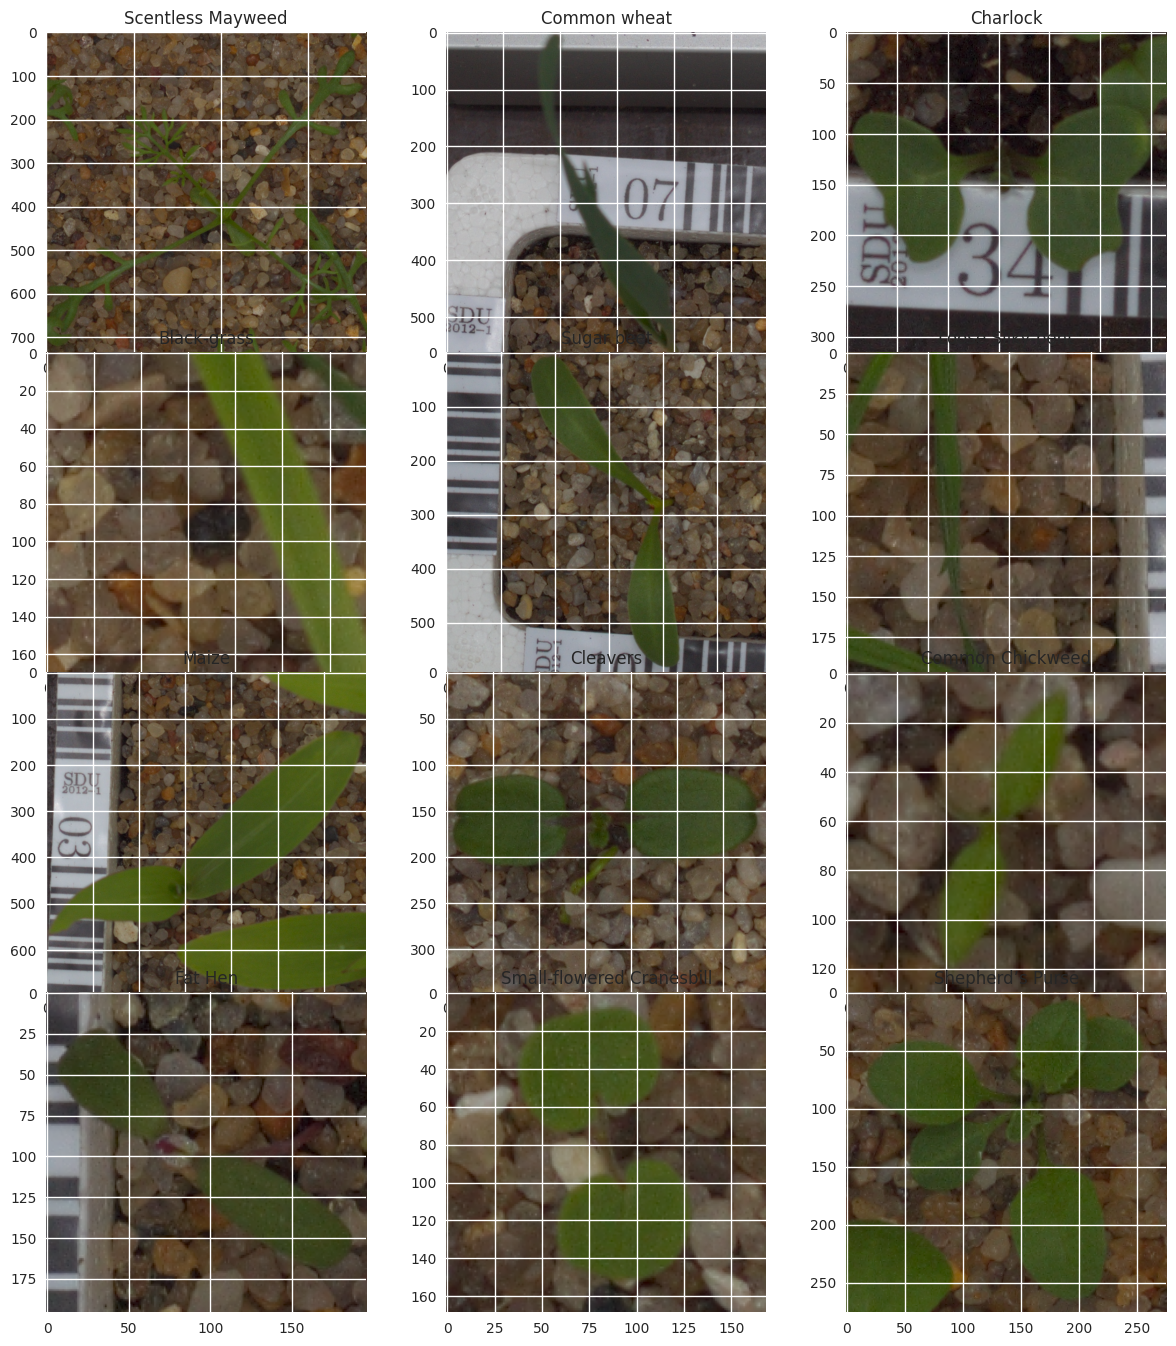

In [9]:
plt.figure(figsize=(15,12))
num_rows, num_cols = 3, 3
for i, unique_label in enumerate(df['label'].unique()):
    ax = plt.axes([0.1 + (i % num_cols) * 0.8 / num_cols, 0.9 - (i // num_cols) * 0.8 / num_rows, 0.8 / num_cols, 0.8 / num_rows])
    ax.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    ax.set_title(unique_label)
plt.show()

In [10]:
x = []
for img_path in df['path']:
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64)) # Görüntüyü 32x32 boyutuna küçült
            img = img.astype(np.uint8) # Float64 yerine uint8 kullan
            img = img / 255.0 # Normalize et
            x.append(img)
    else:
        print(f"Görüntü dosyası bulunamadı: {img_path}")

x = np.array(x)
print(x.shape)

(11078, 64, 64, 3)


In [11]:
y=df['label_encoded']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming x is your input features and y is your labels
# Check if the lengths are the same
if len(x) != len(y):
    # Find the common indices where both x and y have data
    common_indices = np.intersect1d(np.where(~np.isnan(x))[0], np.where(~np.isnan(y))[0])
    
    # Subset x and y to only include the common indices
    x = x[common_indices]
    y = y[common_indices]

# Now you can safely split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [14]:
class_names=['Scentless Mayweed',
 'Common wheat',
 'nonsegmentedv2',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherd’s Purse']

In [15]:
input_size = (64, 64, 3)

In [16]:
model=Sequential()
model.add(Input(shape=input_size))
model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(36, activation='softmax')) # 10 fakli cevap classification 0-9 a kadar olan rakamlar
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,867,364 (7.12 MB)

 Trainable params: 1,867,364 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 34s 233ms/step - accuracy: 0.2716 - loss: 2.2485 - val_accuracy: 0.6133 - val_loss: 1.1664
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - accuracy: 0.6615 - loss: 1.0167 - val_accuracy: 0.7121 - val_loss: 0.8617
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - accuracy: 0.7794 - loss: 0.7012 - val_accuracy: 0.7884 - val_loss: 0.6784
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.8496 - loss: 0.4956 - val_accuracy: 0.7956 - val_loss: 0.6165
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.9003 - loss: 0.3437 - val_accuracy: 0.8357 - val_loss: 0.5253


In [19]:
from fastai.vision.all import * 

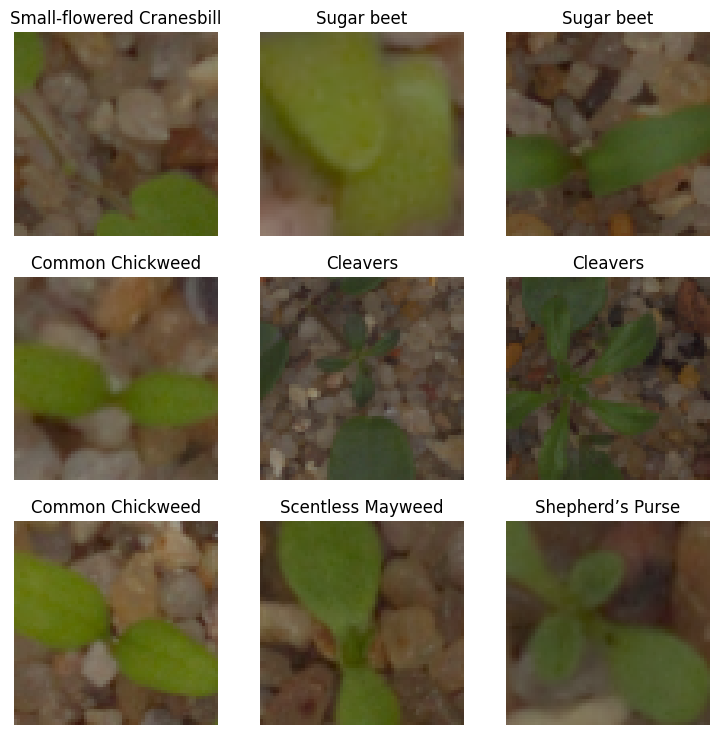

In [25]:
rand_seed = None
path = '/kaggle/input/v2-plant-seedlings-dataset'


def get_dls(size=64, bs=64):
    db = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        splitter=RandomSplitter(seed=rand_seed),
        item_tfms=Resize(280),
        batch_tfms=aug_transforms(size=size, min_scale=0.3)
    )
    return db.dataloaders(path, bs=bs)

dls = get_dls(size=64, bs=64)
dls.show_batch()

In [26]:

# Learner'ı oluşturun
learn = vision_learner(dls, resnet18, 
                        metrics=[accuracy, F1Score(average="micro")]).to_fp16()

# Modeli eğitin
learn.fit_one_cycle(20, wd=0.01)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/torch/amp/gra

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.436768,2.367622,0.234763,0.234763,04:01
1,2.639312,1.815202,0.426637,0.426637,03:26
2,1.971110,1.364133,0.549887,0.549887,03:23
3,1.484290,1.082708,0.636569,0.636569,03:22
4,1.173844,0.918637,0.688036,0.688036,03:29
5,0.916793,0.796051,0.720542,0.720542,03:26
6,0.823779,0.673110,0.749436,0.749436,03:22
7,0.699249,0.616076,0.773363,0.773363,03:22
8,0.650803,0.559551,0.800451,0.800451,03:24
9,0.586872,0.539053,0.803612,0.803612,03:21
